In [13]:
import numpy as np
import scipy as sp 
from methods import *
import matplotlib.pyplot as plt

#### a)

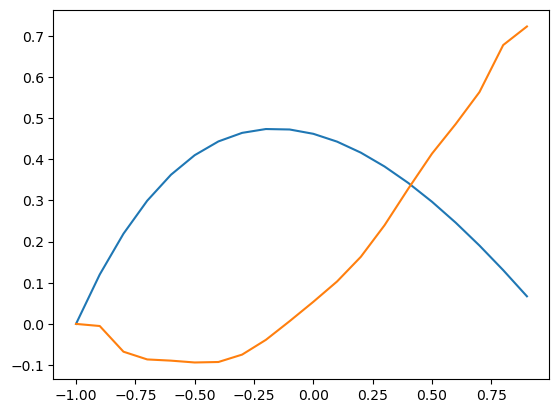

In [14]:
def ffun(x):
    return 1
ffun = np.vectorize(ffun)

def utrue(x,eps):
    return ( np.exp(-x/eps) + x - 1 - np.exp(-1/eps)*x )/( np.exp(-1/eps) - 1 )

def testtrue(x):
    return ( np.exp(2) + 1 - 2*np.exp(1-x) )/(np.exp(2) - 1) - x
testtrue = np.vectorize(testtrue)

m = 20
X = np.arange(m)/m*2 - 1

testsol = LTM_2ord(X, 10, -1, -1, ffun)

plt.figure
plt.plot(X,testtrue(X))
plt.plot(X,testsol)
plt.show()